<div class="alert alert-info">
<strong>Authors:</strong> Oxoli Daniele, Capizzi Emanuele - 2022 - Politecnico di Milano <br>
<strong>License:</strong> MIT
</div>

<div class="alert alert-block alert-success">
<h1>Interactive Copernicus data request using WEkEO HDA API</h1></div>

# NOTEBOOK INTRODUCTION

### Outline

This notebook aims to show how to access to Copernicus data in an interactive way and download/visualize data available from [*<span style='color:Blue'>WEkEO DIAS</span>*](https://www.wekeo.eu/). The structure of the following code can be reused for other available datasets on WEkEO platform by modifying the code appropriately depending on the desired dataset.

This notebook uses the [*<span style='color:Blue'>HDA API</span>*](https://www.wekeo.eu/docs/harmonised-data-access-api) endpoints available at the following link: [*<span style='color:Blue'>Swagger UI</span>*](https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/ui/#!/HDA_-_dataorder/dataorder_get). This link shows the list of operations that can be done in order to perform `GET` and `POST` requests, useful for requesting information and automating data access.

Several example datasets will be used in this notebook to demonstrate how to access them. These have been chosen to show how to use `requests` appropriately depending on the type of data. These differencies will be explained throughout the chapters.

### Interactivity

Adding interactivity to Jupyter Notebooks is undoubtedly very useful for automating certain steps and not having to edit lines of code manually every time you need to change even small parts. The main libraries that in this example will be used for this purpose are [*<span style='color:Blue'>itables</span>*](https://mwouts.github.io/itables/advanced_parameters.html), [*<span style='color:Blue'>ipywidgets</span>*](https://ipywidgets.readthedocs.io/en/latest/index.html#) and [*<span style='color:Blue'>ipywleaflet</span>*](https://ipyleaflet.readthedocs.io/en/latest/).

### Learning outcomes

At the end of this notebook you will know:
* How to access [*<span style='color:Blue'>WEkEO</span>*](https://www.wekeo.eu/) datasets using [*<span style='color:Blue'>HDA API</span>*](https://www.wekeo.eu/docs/harmonised-data-access-api) and the [*<span style='color:Blue'>requests</span>*](https://requests.readthedocs.io/en/latest/) Python library;
* How to access Copernicus data using interactive widgets.
* How to use `GET` and `POST` requests to get data from HDA API.
* Generate visualizations of the requested data using interactive widgets.


### Data used in this notebook

| Product Description | Product Link | WEkEO HDA ID | WEkEO metadata |
|:--------------------:|:-----------------------:|:-----------------:|:-----------------:|
|ERA5 - Single Levels| <a href="https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview" target="_blank">link</a> | EO:ECMWF:DAT:REANALYSIS_ERA5_SINGLE_LEVELS | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AECMWF%3ADAT%3AERA5_HOURLY_VARIABLES_ON_PRESSURE_LEVELS" target="_blank">link</a> |
|CAMS - European Air Quality Forecasts|<a href="https://atmosphere.copernicus.eu/" target="_blank">link</a>|EO:ECMWF:DAT:CAMS_EUROPE_AIR_QUALITY_FORECASTS|<a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AECMWF%3ADAT%3ACAMS_EUROPE_AIR_QUALITY_FORECASTS" target="_blank">link</a>|
|CMEMS - Atlantic- European North West Shelf- Ocean Physics Reanalysis|<a href="https://resources.marine.copernicus.eu/product-detail/NWSHELF_MULTIYEAR_PHY_004_009/INFORMATION" target="_blank">link</a>|EO:MO:DAT:NWSHELF_ANALYSISFORECAST_PHY_LR_004_001:cmems_mod_nws_phy-bottomt_anfc_7km-2D_P1D-m|<a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AMO%3ADAT%3ANWSHELF_ANALYSISFORECAST_PHY_LR_004_001" target="_blank">link</a>|
|Sentinel-5P|<a href="https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-5p" target="_blank">link</a>|'EO:ESA:DAT:SENTINEL-5P:TROPOMI'|<a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AESA%3ADAT%3ASENTINEL-5P%3ATROPOMI" target="_blank">link</a>|

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [Login section](#login)   
 2. [Datasets exploration](#exploration) 
 3. [Section 1 - ERA5 Reanalysis Single Levels](#section1)
 4. [Section 2 - CAMS - Europe Air Quality Forecasts](#section2)
 5. [Section 3 - CMEMS - Analysis/Forecast Sea Bottom Temperature](#section3)
 5. [Section 4 - Sentinel-5P](#section4)


<hr>

<div class="alert alert-info" role="alert">

## <a id='libraries'></a>Import libraries

</div>

In [1]:
# Libraries
import requests
import json
import zipfile
import os
import pandas as pd
from pandas.io.json import json_normalize
import base64
import datetime
import ipywidgets as widgets
from ipywidgets import Layout
import numpy as np
import xarray as xr
import rioxarray as rxr

#Plotting and displaying
import pprint
from PIL import Image
import IPython
from IPython.display import display, JSON, Image
from urllib.request import urlopen
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from netCDF4 import Dataset
from itables import init_notebook_mode, show
import itables.options as opt
opt.classes = ["display","hover", "nowrap"]
init_notebook_mode(all_interactive=True)

#Import custom functions
import custom_WEkEO_methods as m
# %load_ext autoreload
# %autoreload 2

#Warnings
import warnings
warnings.filterwarnings('ignore')

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-9e4k49h8 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<IPython.core.display.Javascript object>

<div class="alert alert-info" role="alert">

## <a id='login'></a> Logging to WEkEO DIAS using HDA API
[Back to top](#TOC_TOP)

</div>

First, in order to access WEkEO data you must create an account on [*<span style='color:Blue'>WEkEO website</span>*](https://www.wekeo.eu/).
The following widget allows to save your WEkEO login credentials in order to obtain the access token in the next step. Start by running the following block of code and type your `Username` and `Password`.

<div class="alert alert-warning" role="alert">
<span>&#9888;</span>
<a id='warning'></a> For all widgets you just need to run the code once and then enter the required information without running the code again (as show in the following GIF).
</div>

![SegmentLocal](images/login.gif "segment")

In [2]:
# Add style variables and get the login box
style= {'description_width': '150px'}
layout = {'width': '500px'}
username = widgets.Text(placeholder="Type WEkEO username",description="Insert username: ",style=style,layout=layout)
password = widgets.Password(placeholder="Type WEkEO password",description="Insert password: ",style=style,layout=layout)

login_box = widgets.VBox([username, password])
login_box

`Username` and `Password` are saved into the respective variables and they are used to retrieve a **temporary** access token.

The following code will perform a `GET` request and it will retrieve the necessary access token. It is also necessary to define a `headers` variable for the authorization.

In [3]:
message = str(username.value+":"+password.value).encode('ascii')
base64_message = base64.b64encode(message).decode('ascii')
headers = {'authorization': 'Basic '+base64_message}  #set headers for get request
token_request = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/gettoken", headers=headers)  #GET Request to API endpoint
token = json.loads(token_request.text)['access_token']
print("Your temporary access token is: "+token) #Print token

Your temporary access token is: 9b3e2332-ec3e-3374-9472-682ac74f26a2


<div class="alert alert-warning" role="alert">
<span>&#9888;</span>
<a id='warning'></a> You may need to get a new access token when the session expires. It's just required to run the previous cell to get a new one.
</div>

In order to access WEkEO data for the first time is necessary to agree `Terms & Conditions`, providing your token inside the `header`:

In [4]:
headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'authorization': 'Basic '+str(token)
}

terms_response = requests.put('https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/termsaccepted/Copernicus_General_License', headers=headers)
terms_status_response = requests.get('https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/termsaccepted/Copernicus_General_License', headers=headers)
terms_status_text = json.loads(terms_status_response.text)
print('Terms and conditions accepted: '+str(terms_status_text['accepted']))

Terms and conditions accepted: True


<div class="alert alert-info" role="alert">

## <a id='exploration'></a> WEkEO datasets exploration
[Back to top](#TOC_TOP)

</div>

First of all, we have to look for the `dataset IDs`, that corresponds to the identifier for a specific dataset. An option is to get the `dataset ID` manually from the WEkEO portal:

![SegmentLocal](images/dataset_id.gif "segment")

Another possibility, similarly to what was done in the login section, is to access to these data using the [*<span style='color:Blue'>requests</span>*](https://docs.python-requests.org/en/latest/) Python library using the correct [*<span style='color:Blue'>HDA API </span>*](https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/ui/#!/HDA_-_dataorder/dataorder_get) endpoint. Finally, we can obtain a [*<span style='color:Blue'>Pandas</span>*](https://pandas.pydata.org/) dataframe containing all the datasets and their information available from WEkEO DIAS. The [*<span style='color:Blue'>itables</span>*](https://mwouts.github.io/itables/advanced_parameters.html) library allows to add interactivity to dataframes in an easy way (the standard Pandas commands are still available).

We can now search for a specific datasets and save its `datasetId`:

In [5]:
size = 2000 # Max number of datasets to be requested
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datasets?size="+str(size)) #GET Request to API endpoint
data = json.loads(dataset.text)
data_df = pd.json_normalize(data['content'])
data_df

abstract  \
0     '''Short description:'''\n\nFor the Global Oce...   
1     '''Short description:'''\n\nFor the Global Oce...   
2     '''Short description:''' \n\nFor the Global Oc...   
3     '''Short description:''' \n\nFor the Global Oc...   
4     '''Short description:''' \n\nFor the Global Oc...   
...                                                 ...   
1014  Dry matter Productivity (DMP) is an indication...   
1015  BA or Burnt Area products provide temporal pat...   
1016  The surface albedo quantifies the fraction of ...   
1017  The surface albedo quantifies the fraction of ...   
1018  WB or Water bodies is a 10-day synthesis produ...   

                                              datasetId  \
0     EO:MO:DAT:WIND_GLO_WIND_L4_REP_OBSERVATIONS_01...   
1     EO:MO:DAT:WIND_GLO_WIND_L4_NRT_OBSERVATIONS_01...   
2     EO:MO:DAT:WIND_GLO_WIND_L3_REP_OBSERVATIONS_01...   
3     EO:MO:DAT:WIND_GLO_WIND_L3_REP_OBSERVATIONS_01...   
4     EO:MO:DAT:WIND_GLO_WIND_L3_REP_OBSERVATIONS_01...   
...                                                 ...   
1014             EO:CLMS:DAT:CGLS_GLOBAL_DMP300_V1_333M   
1015              EO:CLMS:DAT:CGLS_GLOBAL_BA300_V1_333M   
1016                EO:CLMS:DAT:CGLS_GLOBAL_ALDH_V1_1KM   
1017                EO:CLMS:DAT:CGLS_GLOBAL_ALBH_V1_1KM   
1018              EO:CLMS:DAT:CGLS_CONTINENTS_WB_V1_1KM   

                                           previewImage  \
0     https://wekeo-broker-k8s.apps.mercator.dpi.wek...   
1     https://wekeo-broker-k8s.apps.mercator.dpi.wek...   
2     https://wekeo-broker-k8s.apps.mercator.dpi.wek...   
3     https://wekeo-broker-k8s.apps.mercator.dpi.wek...   
4     https://wekeo-broker-k8s.apps.mercator.dpi.wek...   
...                                                 ...   
1014                                               None   
1015  https://wekeo-broker-k8s.apps.mercator.dpi.wek...   
1016                                               None   
1017                                               None   
1018  https://wekeo-broker-k8s.apps.mercator.dpi.wek...   

                                                  title  
0     Global Ocean Wind L4 Reprocessed 6 hourly Obse...  
1     Global Ocean Wind L4 Near real Time 6 hourly O...  
2     Global Ocean Daily Gridded Reprocessed L3 Sea ...  
3     Global Ocean Daily Gridded Reprocessed L3 Sea ...  
4     Global Ocean Daily Gridded Reprocessed L3 Sea ...  
...                                                 ...  
1014              10-daily Dry Matter Productivity 333M  
1015                    Global 10-daily Burnt Area 333m  
1016  Global 10-daily Broadband Directional Surface ...  
1017  Global 10-daily Broadband Hemispherical Surfac...  
1018  10-daily Water Bodies over Africa 1km: Continents  

[1019 rows x 4 columns]

We can begin to download sample datasets using `HDA IDs` to request such data.

----

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Section 1 - ERA5 Reanalysis Single Levels
[Back to top](#TOC_TOP)

</div>

The first dataset that will be used as an example is the `ECMWF ERA5 Reanalysis Single Levels` which provide hourly estimates for a large number of atmospheric, ocean-wave and land-surface quantities. The goal is to understand how to retrieve these data, requesting and visualizing them.

The first step is to store the corresponding `dataset ID` inside a string variable, as follow:

In [6]:
dataset_id = 'EO:ECMWF:DAT:REANALYSIS_ERA5_SINGLE_LEVELS'

### Data preview

With the `GET` request it is possible to filter out the dataset we are interested in, in this case the `ERA5 Reanalysis Single Levels`:

In [7]:
size = 2000
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datasets?size="+str(size))
data = json.loads(dataset.text)
data_df = pd.json_normalize(data['content'])
data_df = data_df[data_df['datasetId'] == dataset_id]
data_df

abstract  \
943  ERA5 is the fifth generation ECMWF reanalysis ...   

                                      datasetId  \
943  EO:ECMWF:DAT:REANALYSIS_ERA5_SINGLE_LEVELS   

                                          previewImage  \
943  https://wekeo-broker-k8s.apps.mercator.dpi.wek...   

                                                 title  
943  ERA5 hourly data on single levels from 1979 to...

As you can see, the Pandas dataframe contains some fields related to the chosen dataset. We now have information about:
 - `Abstract`
 - `HDA dataset ID`
 - `Dataset preview image`
 - `Dataset title`
 
For example, we can use the dataset `title`, `preview image` and the `abstract` to create a simple preview of the dataset, and starting to understand how ipywidgets library can be useful also to data exploration. In this case we can read its description and check whether the dataset it's correct.

First, we create the variables that we want to add to the visualization:

In [8]:
# Get the dataset title from data_df
title = data_df.title.values[0]

# Get the description from data_df
description = list(data_df["abstract"])[0]

# Get the dataset image preview and create a display image using IPython
img_url = list(data_df["previewImage"])[0]
image = IPython.display.Image(img_url, width = 500)
image = widgets.Image(value=image.data,format="jpg", width=500,height=600)

Next, with ipywidgets `HTML` and `Box` controls is possible to create the interface for the visualization, adding styling and spacing to the text and the image:

In [9]:
# Create the boxes
title_box = widgets.HTML(value='<b>'+title+'</b>', disabled=True)
descr_box = widgets.HTML(value=description, disabled=True)
image_box = widgets.VBox([image])
descr_box = widgets.VBox([title_box, descr_box])

# Create the Layout for the dataset preview
ui = widgets.AppLayout(right_sidebar=descr_box, left_sidebar = image_box, layout=widgets.Layout(border='solid'),
                       pane_widths=[1.5,1, 2], pane_heights=[1, 1.7, '100px'], grid_gap='50px')

container = widgets.Box([ui], layout=Layout(height='400px', overflow_y='auto'))
display(container)

Box(children=(AppLayout(children=(VBox(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x0…

### Requirements to create an interactive dashboard

Let's try to create an interactive dashboard that can be useful for easily request data inside this notebook.
Using WEkEO website it is possible to check which information are required to perform the query using the API. The GIF shows how to obtain the query structure and all the parameters necessary to build the dashboard:

![SegmentLocal](images/gif_query.gif "segment")

For `ERA5 Hourly Data On Single Levels` we have to provide the following information:
 - `Variable`: e.g. 2m_temperature
 - `Format type`: e.g. netcdf
 - `Product type`: e.g. ensemble_mean
 - `Year`: e.g. 2020 (or a list of years)
 - `Month`: e.g. 01 for January (or a list of months)
 - `Day`: e.g. 01 (or a list of days)
 - `Time`: e.g. 00:00 (or a list of times)
 
All of them must be provided in string format (or a list of strings).

### Accessing resource metadata

As a first step to build the dashboard we need to access the dataset's `metadata`. The metadata can be requested in JSON format and they contain all the information necessary to create the widgets and finally the dashboard.

The metadata can be obtained using the following `GET` request:

In [10]:
headers = {'authorization': token}
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/querymetadata/"+dataset_id, headers=headers)
metadata = json.loads(dataset.text)

We can interactively visualize the metadata using the display function for `IPython` library. This is very useful to understand how the metadata `JSON` file is structured and how it can be exploited to create the successive query:

In [11]:
display(JSON(metadata))

<IPython.core.display.JSON object>

### Create the widgets

In order to create the widgets we must extract all the information from the `metadata` and store them as lists. You can check the code and try to understand the JSON structure and how is possible to access each variable.

We can extract `ERA5 Hourly Data On Single Levels` variables as follow:

<div class="alert alert-warning" role="alert">
<span>&#9888;</span>
<a id='warning'></a> This step may not be required for other datasets.
</div>

In [12]:
category = metadata['parameters']['multiStringSelects'][0]['details']['groupedValueLabels']
category_list = []
params_list = []
for item in category:
    category_list.append(item['valuesLabels'])

for item in category_list:
    key_list = list(item.keys())
    params_list.append(key_list)

variables_list = [item for sublist in params_list for item in sublist]
# variables_list   # Uncomment to show the variables list

The other parameters can be directly extracted from the metadata inside separate lists:

In [13]:
format_type_list = list(['netcdf'])
product_type_list = list(metadata['parameters']['multiStringSelects'][1]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
year_list = list(metadata['parameters']['multiStringSelects'][2]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
month_list = list(metadata['parameters']['multiStringSelects'][3]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
day_list = list(metadata['parameters']['multiStringSelects'][4]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
time_list = list(metadata['parameters']['multiStringSelects'][5]['details']['groupedValueLabels'][0]['valuesLabels'].keys())

Now we have all the information needed to create a simple personalized interactive dashboard.

In this case, a multiple selection widget `SelectMultiple` is used for all parameters, as we may want to select multiple variables or time periods (check the [*<span style='color:Blue'>ipywidgets documentation</span>*](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html) to get an overview of all the available widgets). A widget for each variable is created, providing the corresponding list to the `option` parameter and assigning the desired styling/layout:

In [14]:
style = {'description_width': '100px'}
layout = {'width': '800px'}
params_sel = widgets.SelectMultiple(options=variables_list,description='Variables: ',disabled=False,style=style,layout=layout)
product_type_sel = widgets.SelectMultiple(options=product_type_list,description="Product type:",disabled=False,style=style,layout=layout)
year_sel = widgets.SelectMultiple(options=year_list,description="Year: ",disabled=False,style=style,layout=layout)
month_sel = widgets.SelectMultiple(options=month_list,description="Month: ",disabled=False,style=style,layout=layout)
day_sel = widgets.SelectMultiple(options=day_list,description="Day: ",disabled=False,style=style,layout=layout)
time_sel = widgets.SelectMultiple(options=time_list,description="Time: ",disabled=False,style=style,layout=layout)
format_type_sel = "netcdf"  #For simplicity only netCDF files are considered (also GRIB files could be used)

### Create the dashboard and request the data

Finally, we can now group all the widgets in a single dashboard interface. Some simple `HTML`/`CSS` code is applied to improve the styling and the widgets are grouped together using the `VBox` container. The following cell can be used to define CSS attributes and improve the styling:

In [15]:
%%html
<style>
.box {
    background: linear-gradient(#abbaab,#eef2f3);
    border: 2px solid #0b385f;
    font-weight: bold;
}

Run the next code and try to select `2m_temperature` using `ensemble_mean` in a given time range (CTRL+left click to select multiple items):

<div class="alert alert-warning" role="alert">
<span>&#9888;</span>
<a id='warning'></a> Longer periods will require more time for data request.
</div>

In [16]:
# Create boxes for the dashboard
title_box= widgets.HTML(value='<h2 style="text-align:center;">'+title+'</h2><hr>')
variables_box = widgets.VBox([title_box, params_sel, product_type_sel, year_sel, month_sel, day_sel, time_sel])

# Create the dashboard 
ui = widgets.AppLayout(
          layout=widgets.Layout(),
          grid_gap="300px")

# Display the variable box
display(variables_box.add_class("box"))

Selecting the parameter in the dashboard above will automatically change the requested data inside the next query. The query will be used for the following API `POST` request. This will send information to the server about the data you want to request.

After the request is completed we can obtain the `Job ID` that will allows us to effectively download the data this time using a `GET` request. Notice also how the `headers` variable changed in the following cell:

In [17]:
query = {
  "datasetId": dataset_id,
  "multiStringSelectValues": [
    {
      "name": "variable",
      "value": list(params_sel.value)
    },
    {
      "name": "year",
      "value": list(year_sel.value)
    },
    {
      "name": "month",
      "value": list(month_sel.value)
    },
    {
      "name": "day",
      "value": list(day_sel.value)
    },
    {
      "name": "time",
      "value":list(time_sel.value)
    },
    {
      "name": "product_type",
      "value": list(product_type_sel.value)
    }
  ],
  "stringChoiceValues": [
    {
      "name": "format",
      "value": format_type_sel
    }
  ]
}

headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'authorization': 'Basic '+str(token)
}

data = json.dumps(query)
dataset_post = requests.post("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datarequest", headers=headers, data=data)
job_id = json.loads(dataset_post.text)
jobId = job_id['jobId']
print("The job ID is: "+jobId+". The status is: "+job_id['status'])

The job ID is: dxY_7ol4pUR-EUZ-JUHlZJLVF78. The status is: started


Next, we can check the whether the request is completed (You must wait until it is completed. If an error occurs check if the parameters are selected correctly inside the dashboard):

In [18]:
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
get_url = json.loads(get_url_request.text)
if get_url['status']=='completed':
    print('Status: Completed', end='\r')

while get_url['status']!='completed':
    get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
    get_url = json.loads(get_url_request.text)
    if get_url['status']=='running':
        print('Status: Running', end='\r')
    elif get_url['status']=='failed':
        print('Status: Failed. Check data selected.')
        break
    elif get_url['status']=='completed':
        print('Status: Completed')

Status: Completed


We are ready to perform a `GET` request to effectively obtain the selected data (notice that the `headers` changed again since we changed the request). The URL for the download will be provided:

In [19]:
headers = {'authorization': 'Basic '+str(token)}
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/jobs/'+jobId+'/result', headers=headers)
get_url = json.loads(get_url_request.text)
url = get_url['content'][0]['url']
print('The URL for download is: '+ get_url['content'][0]['url'])

The URL for download is: https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data4/adaptor.mars.internal-1657271894.3147523-18413-4-f25a8e52-efa8-4fbb-a3f0-49bb9aaa8eb0.nc


One of the main advantages of accessing data using the API is being able to interact directly without necessarily having to save files in the local storage. The following `RadioButtons` widget can be used to decide whether we want to locally download the netCDF file in the working directory or read it directly into memory from the URL without saving:

### Read or download the data

In [20]:
download_list = ["Download NETCDF", "Read NETCDF in memory"] #Choice - Download data or just read
download_sel = widgets.RadioButtons(options=download_list,description="Data download: ", value="Read NETCDF in memory")
download_sel

RadioButtons(description='Data download: ', index=1, options=('Download NETCDF', 'Read NETCDF in memory'), val…

The `download_type` function uses the xarray library to read netCDF files. This function can be used for this purpose (check the to have more details):

In [21]:
ds = m.download_type(download_sel, download_list, get_url)

### Interactive visualization

We are ready to plot the netCDF file previously requested. We can extract the variables and the times inside specific lists and pass them to a `Dropdown` widget as `option`:

In [22]:
# Select the netCDF variables
variables = list(ds.keys())
var_drop = widgets.Dropdown(options = variables, description= "Variable: ",style={'description_width': '100px'},layout ={'width': '400px'})

# Select the netCDF times
timings = list(ds.time.data)
time_drop = widgets.Dropdown(options=timings,description="Select date: ",disabled=False,style={'description_width': '100px'},layout ={'width': '400px'})

Next we define the function for visualizing ERA5 data and use the `interact` widgets to update the visualization when the selected parameter is changed (a moment may be necessary to visualize the updated plot):

In [23]:
def plot_era5(variable, time):
    f = plt.figure(figsize=(15,10))
    p = ds[var_drop.value].sel(time=time_drop.value).plot.pcolormesh(  #change time
        subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
        transform=ccrs.PlateCarree())
    p.set_clim(ds[var_drop.value].min(),ds[var_drop.value].max())
    p.axes.set_global()  #global
    p.axes.coastlines()  #coastlines
    p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    p.axes.set_extent([-180, 180, -90, 90], ccrs.PlateCarree()) #extent window

    # draw gridlines
    gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')

    # adjust labels
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.AutoLocator()
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 18, 'color': 'black'}
    gl.ylabel_style = {'size': 18, 'color': 'black'}

In [24]:
widgets.interact(plot_era5, variable = var_drop, time=time_drop)

interactive(children=(Dropdown(description='Variable: ', layout=Layout(width='400px'), options=('t2m',), style…

<function __main__.plot_era5(variable, time)>

----

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Section 2 - CAMS - Europe Air Quality Forecasts
[Back to top](#TOC_TOP)

</div>

As second dataset the European Air Quality Forecast (CAMS) will be used.

First of all, select `EO:ECMWF:DAT:CAMS_EUROPE_AIR_QUALITY_FORECASTS` using its HDA ID:

In [25]:
dataset_id = 'EO:ECMWF:DAT:CAMS_EUROPE_AIR_QUALITY_FORECASTS'

Retrieve the dataset information using its `ID`:

In [26]:
size = 2000
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datasets?size="+str(size))
data = json.loads(dataset.text)
data_df = pd.json_normalize(data['content'])
data_df = data_df[data_df['datasetId'] == dataset_id]
data_df

abstract  \
979  This dataset provides daily air quality analys...   

                                          datasetId  \
979  EO:ECMWF:DAT:CAMS_EUROPE_AIR_QUALITY_FORECASTS   

                                          previewImage  \
979  https://wekeo-broker-k8s.apps.mercator.dpi.wek...   

                                   title  
979  CAMS European air quality forecasts

As we did in the previous chapter, let's create a preview for the `Copernicus CAMS European Air Quality Forecast` dataset:

In [27]:
# Get the dataset title from data_df
title = data_df.title.values[0]

# Get the description from data_df
description = list(data_df["abstract"])[0].replace("�", "\u03BC")

# Get the dataset image preview and create a display
img_url = list(data_df["previewImage"])[0]
image = IPython.display.Image(img_url, width = 500)
image = widgets.Image(value=image.data,format="jpg", width=500,height=600)

In [28]:
# Create the boxes
title_box = widgets.HTML(value='<b>'+title+'</b>', disabled=True)
descr_box = widgets.HTML(value=description, disabled=True)
image_box = widgets.VBox([image])
descr_box = widgets.VBox([title_box, descr_box])

# Create the Layout for the dataset preview
ui = widgets.AppLayout(right_sidebar=descr_box, left_sidebar = image_box, layout=widgets.Layout(border='solid'),pane_widths=[1.5,1, 2],
          pane_heights=[0.5, 3, '60px'], grid_gap='20px')
container = widgets.Box([ui], layout=Layout(height='400px', overflow_y='auto'))
display(container)

Box(children=(AppLayout(children=(VBox(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02…

Always using WEkEO website we can check the information required to create the query for CAMS European Air Quality Forecast. In this example we must define multiple variables:
- `Bounding Box`
- `Date Range`
- `Variable`
- `Model`
- `Level`
- `Type`
- `Time`
- `Leadtime Hour`
- `Format`

Let's access dataset metadata and visualize the JSON file structure for this dataset:

In [29]:
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/querymetadata/"+dataset_id, headers=headers)
metadata = json.loads(dataset.text)

In [30]:
display(JSON(metadata))

<IPython.core.display.JSON object>

Create the lists contaning the values for each parameter required by the query:

In [31]:
format_type_list = list(['netcdf'])
params_list = list(metadata['parameters']['multiStringSelects'][0]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
product_type_list = list(metadata['parameters']['multiStringSelects'][1]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
level_list = list(metadata['parameters']['multiStringSelects'][2]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
type_list = list(metadata['parameters']['multiStringSelects'][3]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
hour_list = list(metadata['parameters']['multiStringSelects'][4]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
leadtime_list = list(metadata['parameters']['multiStringSelects'][5]['details']['groupedValueLabels'][0]['valuesLabels'].keys())

Create the widgets for the interactive dashboard. We use a `SelectMultiple` widget for all the variables except for the date, for which we use a `DatePicker` widget:

In [32]:
params_sel = style = {'description_width': '100px'}
layout = {'width': '400px'}

params_sel = widgets.SelectMultiple(options=params_list,description='Variables: ',disabled=False,style=style,layout=layout)
product_type_sel = widgets.SelectMultiple(options=product_type_list,description='Product type: ',disabled=False,style=style,layout=layout)
level_sel = widgets.SelectMultiple(options=level_list,description='Level: ',disabled=False,style=style,layout=layout)
type_sel = widgets.SelectMultiple(options=type_list,description='Type: ',disabled=False,style=style,layout=layout)
hour_sel = widgets.SelectMultiple(options=hour_list,description='Hour: ',disabled=False,style=style,layout=layout)
leadtime_sel = widgets.SelectMultiple(options=leadtime_list,description='Leadtime: ',disabled=False,style=style,layout=layout)
format_type_sel = "netcdf"
start_date_sel = widgets.DatePicker(description='Select start date: ',disabled=False,style=style,layout=layout)
end_date_sel = widgets.DatePicker(description='Select end date: ',disabled=False,style=style,layout=layout)

For the `CAMS European Air Quality Forecast` dataset we can provide a `Bounding Box` contanining the Region of Interest for which we want to require the data. 
An interactive way to select the Bounding Box is to use the [*<span style='color:Blue'>Ipyleaflet</span>*](https://ipyleaflet.readthedocs.io/en/latest/) library. The  function `draw_map` it's available inside the custom functions, created using this library. The following code will generate a map and with the `Draw a Rectangle` tool the desired area can be selected:

In [33]:
cams_map, dc = m.draw_map(45, 10, 4)  # lat=45, lon=10, zoom=4

cams_map

Map(center=[45, 10], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

The `Bounding Box` coordinates can be obtained (of course you can change W,E, N, S variables values if specific coordinates must be used):

In [34]:
coords = dc.last_draw['geometry']['coordinates'][0]
W = coords[1][0]
E = coords[3][0]
N = coords[1][1]
S = coords[3][1]

It's also important to check the time range for the available data:

In [35]:
start_date = metadata['parameters']['dateRangeSelects'][0]['details']['start']
print("The start date for this dataset is: "+start_date+". You can select data after this date.")

The start date for this dataset is: 2019-03-26. You can select data after this date.


Now it's possible to create a dashboard as we did during the previous chapter, but this time we will use the widgets specifically created for the `CAMS European Air Quality Forecast` dataset. Try to select the following data:
- `variable` ammonia
- `product type` ensemble
- `level` 0
- `type` analysis
- `leadtime hour` 0
- `hour` 12:00
- `start-end date` from 01/03/2020 to 01/04/2020

In [36]:
%%html
<style>
.box {
    background: linear-gradient(#abbaab,#eef2f3);
    border: 2px solid #0b385f;
    font-weight: bold;
}

In [37]:
# Create boxes for the dashboard
title_box= widgets.HTML(value='<h2 style="text-align:center;">'+title+'</h2><hr>')
variables_box = widgets.VBox([title_box, params_sel, product_type_sel, level_sel, type_sel, hour_sel, leadtime_sel, start_date_sel, end_date_sel])

# Create the dashboard 
ui = widgets.AppLayout(
          layout=widgets.Layout(),
          grid_gap="300px")

display(variables_box.add_class("box"))

We can run the query after selecting the proper values inside the dashboard:

In [38]:
query = {
      "datasetId": dataset_id,
      "boundingBoxValues": [
        {
          "name": "area",
          "bbox": [
            W,
            N,
            E,
            S
          ]
        }
      ],
      "dateRangeSelectValues": [
        {
          "name": "date",
          "start": start_date_sel.value.strftime("%Y-%m-%dT%H:%M:%S.000Z"),
          "end": end_date_sel.value.strftime("%Y-%m-%dT%H:%M:%S.000Z")
        }
      ],
      "multiStringSelectValues": [
        {
          "name": "variable",
          "value": list(params_sel.value)
        },
        {
          "name": "model",
          "value": list(product_type_sel.value)
        },
        {
          "name": "level",
          "value": list(level_sel.value)
        },
        {
          "name": "type",
          "value": list(type_sel.value)
        },
        {
          "name": "time",
          "value": list(hour_sel.value)
        },
        {
          "name": "leadtime_hour",
          "value": list(leadtime_sel.value)
        }
      ],
      "stringChoiceValues": [
        {
          "name": "format",
          "value": format_type_sel
        }
      ]
    }
      
headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'authorization': 'Basic '+str(token)}

data = json.dumps(query)
dataset_post = requests.post("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datarequest", headers=headers, data=data)
job_id = json.loads(dataset_post.text)
print(job_id)
jobId = job_id['jobId']
print("The job ID is: "+jobId+". The status is: "+job_id['status'])

{'jobId': '_OXqwFrZdWIjeVjht7VRf6TifUA', 'status': 'started', 'results': [], 'message': None}
The job ID is: _OXqwFrZdWIjeVjht7VRf6TifUA. The status is: started


Check the `Job ID` status (if it fails, stop the code block, check the query parameters and re-run the query):

In [39]:
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
get_url = json.loads(get_url_request.text)
if get_url['status']=='completed':
    print('Status: Completed', end='\r')

while get_url['status']!='completed':
    get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
    get_url = json.loads(get_url_request.text)
    if get_url['status']=='running':
        print('Status: Running', end='\r')
    elif get_url['status']=='failed':
        print('Status: Failed. Check data selected.')
        break
    elif get_url['status']=='completed':
        print('Status: Completed')

Status: Completed


Now we can download the data in netCDF format:

In [40]:
headers = {'authorization': 'Basic '+str(token)}
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/jobs/'+jobId+'/result', headers=headers)
get_url = json.loads(get_url_request.text)
# print(get_url)
url = get_url['content'][0]['url']
print('The URL for download is: '+ get_url['content'][0]['url'])

The URL for download is: https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data0/adaptor.cams_regional_fc.retrieve-1657271984.5728903-14242-15-54d2f91f-b70f-4352-bad7-ecf705aab3ef.nc


We can decide whether we want to download the netCDF file with its original name or read it directly into memory:

In [41]:
download_list = ["Download NETCDF", "Read NETCDF in memory"] #Choice - Download data or just read
download_sel = widgets.RadioButtons(options=download_list,description="Data download: ", value="Read NETCDF in memory")
download_sel

RadioButtons(description='Data download: ', index=1, options=('Download NETCDF', 'Read NETCDF in memory'), val…

It's possible to download or read in memory the netCDF file and then proceed to plot the file:

In [42]:
ds = m.download_type(download_sel, download_list, get_url)
ds

<xarray.Dataset>
Dimensions:    (longitude: 145, latitude: 59, level: 1, time: 31)
Coordinates:
  * longitude  (longitude) float32 1.75 1.85 1.95 2.05 ... 15.95 16.05 16.15
  * latitude   (latitude) float32 48.05 47.95 47.85 47.75 ... 42.45 42.35 42.25
  * level      (level) float32 0.0
  * time       (time) timedelta64[ns] 0 days 1 days 2 days ... 29 days 30 days
Data variables:
    nh3_conc   (time, level, latitude, longitude) float32 ...
Attributes:
    title:        NH3 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Aarhus University (Denmark)
    source:       Data from DEHM model
    history:      Model DEHM ANALYSIS
    ANALYSIS:     Europe, 20200601-20200701+[0H_0H]
    summary:      DEHM model hourly ANALYSIS of NH3 concentration at the Surf...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

Since the `time` variable for this dataset is save as timedelta, we need to change it from `timedelta` to `datetime`:

In [43]:
timestamp = ds.time.long_name[19:27]
time_start= int(hour_sel.value[0][0:2])  #if using data starting at different hour (e.g. 2020-01-01 at 14PM -> set to 14). Must check with multiple hours
timestamp_init=datetime.datetime.strptime(timestamp,'%Y%m%d')+datetime.timedelta(hours=time_start)
time_coords = pd.date_range(timestamp_init, periods=len(ds.time), freq='1d').strftime("%Y-%m-%d %H:%M:%S").astype('datetime64[ns]')

In [44]:
ds_assign = ds.assign_coords(time=time_coords)
ds_assign = ds_assign.assign_coords(longitude=(((ds_assign.longitude + 180) % 360) - 180)).sortby('longitude')
ds_assign

<xarray.Dataset>
Dimensions:    (longitude: 145, latitude: 59, level: 1, time: 31)
Coordinates:
  * longitude  (longitude) float32 1.75 1.85 1.95 2.05 ... 15.95 16.05 16.15
  * latitude   (latitude) float32 48.05 47.95 47.85 47.75 ... 42.45 42.35 42.25
  * level      (level) float32 0.0
  * time       (time) datetime64[ns] 2020-06-01 2020-06-02 ... 2020-07-01
Data variables:
    nh3_conc   (time, level, latitude, longitude) float32 ...
Attributes:
    title:        NH3 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Aarhus University (Denmark)
    source:       Data from DEHM model
    history:      Model DEHM ANALYSIS
    ANALYSIS:     Europe, 20200601-20200701+[0H_0H]
    summary:      DEHM model hourly ANALYSIS of NH3 concentration at the Surf...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

In [45]:
# Select the netCDF variables
variables = list(ds.keys())
var_drop = widgets.Dropdown(options=variables,description='Variables: ',disabled=False,style={'description_width': '100px'},layout ={'width': '400px'})
# Select the netCDF times
timings = list(ds_assign.time.data)
time_drop = widgets.Dropdown(options=timings,description="Select date: ",disabled=False,style={'description_width': '100px'},layout ={'width': '400px'})

We are ready to plot the data for the selected variable and date:

In [46]:
def cams_plot(variable, time):  
    f = plt.figure(figsize=(15,10))
    p = ds_assign[var_drop.value].sel(time=time_drop.value).plot(  #change time
    subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
    transform=ccrs.PlateCarree())
    p.set_clim(ds_assign[var_drop.value].min(),ds_assign[var_drop.value].max())
    p.axes.set_global()
    p.axes.coastlines()
    p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    p.axes.set_extent([W-1,E+1,S-1,N+1], ccrs.PlateCarree())
 
    gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')

    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.AutoLocator()
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 18, 'color': 'black'}
    gl.ylabel_style = {'size': 18, 'color': 'black'}

In [47]:
widgets.interact(cams_plot, variable = var_drop, time=time_drop)

interactive(children=(Dropdown(description='Variables: ', layout=Layout(width='400px'), options=('nh3_conc',),…

<function __main__.cams_plot(variable, time)>

An additional step could be to use the `Ipyleaflet` functionalities to select a specific location and check the corresponding time series for the select location. We plot the map again and with the `Draw a Marker` tool we can select a location inside the previously selected `Bounding Box`:

In [48]:
cams_map

Map(bottom=1673.0, center=[45, 10], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

We get the `longitude` and the `latitude` of the location and we can plot the time serie for the selected variable and location:

In [49]:
coords = dc.last_draw['geometry']['coordinates']
lati=coords[1]
loni=coords[0]

var = ds_assign.sel(longitude=loni, latitude=lati, method='nearest')[var_drop.value]

Text(3, 3, 'Location')

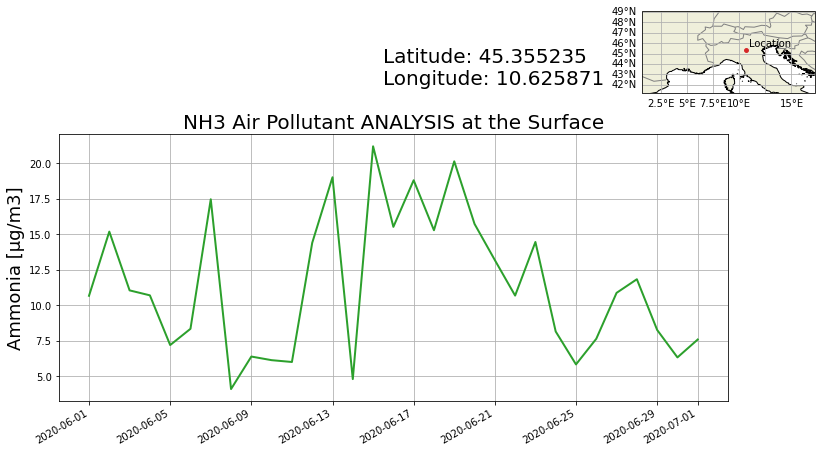

In [50]:
f = plt.figure(figsize=(12,12))
ax=f.add_subplot(211)

ax.set_title(ds_assign.title , fontsize=20)
ax.grid()
ax.set_ylabel(ds_assign[var_drop.value].species+' '+'['+ds_assign[var_drop.value].units+']', fontsize=18)
ax.plot(ds_assign.time, var,c='tab:green', linewidth=2)
f.suptitle('Latitude: '+str(lati)+' \nLongitude: '+str(loni),ha= 'left', fontsize=20)
f.autofmt_xdate()

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_boundary_lines_land',
        scale='110m',
        facecolor='none')
ax_mini_map = f.add_axes([0.8, 0.90, 0.2, 0.15], projection=ccrs.PlateCarree())
gl = ax_mini_map.axes.gridlines(draw_labels=True)
ax_mini_map.add_feature(states_provinces, edgecolor='gray')
gl.xlabels_top = False
gl.ylabels_right = False
ax_mini_map.add_feature(cfeature.LAND, zorder= 0, edgecolor='k')
ax_mini_map.set_extent([W-1,E+1,S-1,N+1])
ax_mini_map.scatter(loni, lati, 15, 'tab:red', transform=ccrs.PlateCarree())
ax_mini_map.annotate('Location', (loni, lati),xytext=(3, 3), textcoords='offset points')

----

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Section 3 - CMEMS - Analysis/Forecast Sea Bottom Temperature
[Back to top](#TOC_TOP)

</div>

The structure of this section is similar to the previous. In this case we will consider the `Copernicus Marine Service (CMEMS) Atlantic - European North West Shelf - Ocean Physics Analysis and Forecast`. We are going to select it using the following id :

In [ ]:
dataset_id = 'EO:MO:DAT:NWSHELF_ANALYSISFORECAST_PHY_LR_004_001:cmems_mod_nws_phy-bottomt_anfc_7km-2D_P1D-m'

As usual is possible to generate the dataset preview, in the same way we did in the previous examples:

In [ ]:
size = 2000
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datasets?size="+str(size))
data = json.loads(dataset.text)
data_df = pd.json_normalize(data['content'])
data_df = data_df[data_df['datasetId'] == dataset_id]
data_df

In [ ]:
# Get the dataset title from data_df
title = data_df.title.values[0]

# Get the description from data_df
description = list(data_df["abstract"])[0]

# Get the dataset image preview and create a display
img_url = list(data_df["previewImage"])[0]
image = IPython.display.Image(img_url, width = 500)
image = widgets.Image(value=image.data,format="jpg", width=500,height=600)

In [ ]:
# Create the boxes
title_box = widgets.HTML(value='<b>'+title+'</b>', disabled=True)
descr_box = widgets.HTML(value=description, disabled=True)
image_box = widgets.VBox([image])
descr_box = widgets.VBox([title_box, descr_box])

# Create the Layout for the dataset preview
ui = widgets.AppLayout(right_sidebar=descr_box, left_sidebar = image_box, layout=widgets.Layout(border='solid'),pane_widths=[1.2,1, 2],
          pane_heights=[0.5, 3, '40px'], grid_gap='10px')
container = widgets.Box([ui], layout=Layout(height='400px', overflow_y='auto'))
display(container)

For this dataset we have to define only:
- `Bounding Box`
- `Start-end date`

Let's start requesting the dataset `metadata`:

In [ ]:
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/querymetadata/"+dataset_id, headers=headers)
metadata = json.loads(dataset.text)

Again, visualize the JSON structure:

In [ ]:
display(JSON(metadata))

Create the lists using the `metadata`, generate the `DatePicker` widget for the start/end date selection:

In [ ]:
variable_list = list(metadata['parameters']['multiStringSelects'][0]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
end = metadata['parameters']['dateRangeSelects'][0]['details']['end']
start = metadata['parameters']['dateRangeSelects'][0]['details']['start']
print("The start date for this dataset is "+start+". The end date is "+end)

In [ ]:
params_sel = style = {'description_width': '100px'}
layout = {'width': '400px'}

start_date_sel = widgets.DatePicker(description='Select start date: ',disabled=False,style=style,layout=layout)
end_date_sel = widgets.DatePicker(description='Select end date: ',disabled=False,style=style,layout=layout)

Generate the interactive map and draw the Region of Interest using the `Draw a rectangle` tool:

In [ ]:
cams_map, dc = m.draw_map(50, -10, 4)  #lat=50, lon=-10, zoom=4

cams_map

Get the coordinates from the Region of Interest:

In [ ]:
coords = dc.last_draw['geometry']['coordinates'][0]
W = coords[1][0]
E = coords[3][0]
N = coords[1][1]
S = coords[3][1]

Next we can select the start and the end date:

In [ ]:
# Create boxes for the dashboard
title_box = widgets.HTML(value='<b>'+title+'</b>', disabled=True)
variables = widgets.VBox([title_box, start_date_sel, end_date_sel])

# Create the dashboard 
ui = widgets.AppLayout(layout=widgets.Layout(), grid_gap="300px")

display(variables.add_class("box"))

Request data using the query and obtain the `Job ID`:

In [ ]:
query = {
  "datasetId": dataset_id,
  "boundingBoxValues": [
    {
      "name": "bbox",
      "bbox": [W, S, E, N]
    }
  ],
  "dateRangeSelectValues": [
    {
      "name": "position",
      "start": start_date_sel.value.strftime("%Y-%m-%dT%H:%M:%S.000Z"),
      "end": end_date_sel.value.strftime("%Y-%m-%dT%H:%M:%S.000Z")
    }
  ],
  "multiStringSelectValues": [
    {
      "name": "variable",
      "value": [
        "bottomT"
      ]
    }
  ],
  "stringChoiceValues": [
    {
      "name": "service",
      "value": "NWSHELF_ANALYSISFORECAST_PHY_LR_004_001-TDS"
    },
    {
      "name": "product",
      "value": "cmems_mod_nws_phy-bottomt_anfc_7km-2D_P1D-m"
    }
  ]
}

headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'authorization': 'Basic '+str(token)}

data = json.dumps(query)
dataset_post = requests.post("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datarequest", headers=headers, data=data)
job_id = json.loads(dataset_post.text)
print(job_id)
jobId = job_id['jobId']
print("The job ID is: "+jobId+". The status is: "+job_id['status'])

Check the `Job ID` status if completed:

In [ ]:
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
get_url = json.loads(get_url_request.text)
if get_url['status']=='completed':
    print('Status: Completed', end='\r')

while get_url['status']!='completed':
    get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
    get_url = json.loads(get_url_request.text)
    if get_url['status']=='running':
        print('Status: Running', end='\r')
    elif get_url['status']=='failed':
        print('Status: Failed. Check data selected.')
        break
    elif get_url['status']=='completed':
        print('Status: Completed')

As we did in the previous examples, we can request the data using the `GET` request providing the `JOB ID`:

In [ ]:
headers = {'authorization': 'Basic '+str(token)}
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/jobs/'+jobId+'/result', headers=headers)
get_url = json.loads(get_url_request.text)
url = get_url['content'][0]['url']
filename = get_url['content'][0]['productInfo']['product']  #select filename for saving
print('The URL for download is: '+ get_url['content'][0]['url'])

For this dataset (differently from the previous chapters) it is also required to `Order` the data, using a `POST` request and providing the `URL` obtained in the previous step. We can do it as follow:

In [ ]:
url = get_url['content'][0]['url']

headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'authorization': 'Basic '+str(token)}

query = {
    "jobId":str(jobId),
    "uri":str(url)
    }

data = json.dumps(query)
dataset_post_order = requests.post("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/dataorder", headers=headers, data=data)
dataset_post_order_text = dataset_post_order.text
order_id = json.loads(dataset_post_order_text)['orderId']

Finally, it is possible to download the netCDF file we ordered previsouly using again a `GET` request and providing the `Order ID`. In this case the ordered file will be saved in your working directory with its original name (stored in the `filename` variable):

In [ ]:
headers = {'Accept': 'application/x-netcdf'}
response_order = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/dataorder/download/"+order_id, headers=headers)

The downloaded file can be saved with the `.nc` format (netCDF), imported with `xarray` and visualized:

In [ ]:
file = open(filename+".nc", "wb")
file.write(response_order.content)
file.close()

Read the netCDF file:

In [ ]:
ds = xr.open_dataset(filename+".nc")
ds

Create lists using the data variables and the time:

In [ ]:
variables = list(ds.keys())
var_drop = widgets.Dropdown(options=variables, description="Variable: ",disabled=False,style={'description_width': '100px'},layout ={'width': '400px'})
# Select the netCDF times
timings = list(ds.time.data)
time_drop = widgets.Dropdown(options=timings,description="Select date: ",disabled=False,style={'description_width': '100px'},layout ={'width': '400px'})

In [ ]:
def cmems_plot(variable, time):
    plt.figure(figsize=(20, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    p = ds[var_drop.value].sel(time=time_drop.value).plot.pcolormesh(
        ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude")
    p.set_clim(vmin=ds[var_drop.value].min(), vmax=ds[var_drop.value].max())
    ax.coastlines()

    p.axes.set_global()
    p.axes.coastlines()
    p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    p.axes.set_extent([W-1,E+1,S-1,N+1], ccrs.PlateCarree())

    # draw parallels/meridiens and write labels
    gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')

    # adjust labels to taste
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.AutoLocator()
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 18, 'color': 'black'}
    gl.ylabel_style = {'size': 18, 'color': 'black'}

In [ ]:
widgets.interact(cmems_plot, variable = var_drop, time=time_drop)

-------

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Section 4 - Sentinel-5P
[Back to top](#TOC_TOP)

</div>

In [ ]:
dataset_id = 'EO:ESA:DAT:SENTINEL-5P:TROPOMI'

Select 'EO:ECMWF:DAT:CAMS_EUROPE_AIR_QUALITY_FORECASTS' from the Dropdown list:

In [ ]:
size = 2000
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datasets?size="+str(size))
data = json.loads(dataset.text)
data_df = pd.json_normalize(data['content'])
data_df = data_df[data_df['datasetId'] == dataset_id]
data_df

In [ ]:
# Get the dataset title from data_df
title = data_df.title.values[0]
# No image for S5P
# Get the description from data_df
description = list(data_df["abstract"])[0]

In [ ]:
# Create the boxes
title_box = widgets.HTML(value='<b>'+title+'</b>', disabled=True)
descr_box = widgets.HTML(value=description, disabled=True)

descr_box = widgets.VBox([title_box, descr_box])

# Create the Layout for the dataset preview
ui = widgets.AppLayout(right_sidebar=descr_box, layout=widgets.Layout(border='solid'),pane_widths=[1.5,1, 2],
          pane_heights=[0.5, 3, '60px'], grid_gap='50px')
container = widgets.Box([ui], layout=Layout(height='300px', overflow_y='auto'))
display(container)

In [ ]:
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/querymetadata/"+dataset_id, headers=headers)
metadata = json.loads(dataset.text)

In [ ]:
display(JSON(metadata))

In [ ]:
processing_level_list = list(metadata['parameters']['stringChoices'][0]['details']['valuesLabels'].keys())
product_type_list = list(metadata['parameters']['stringChoices'][1]['details']['valuesLabels'].keys())
timeliness_list = list(metadata['parameters']['stringChoices'][2]['details']['valuesLabels'].keys())

In [ ]:
style = {'description_width': '100px'}
layout = {'width': '400px'}
processing_level_sel = widgets.SelectMultiple(options=processing_level_list, description="Processing level:",disabled=False,style=style,layout=layout)
product_type_sel = widgets.SelectMultiple(options=product_type_list, description="Product type:",disabled=False,style=style,layout=layout)
timeliness_sel = widgets.SelectMultiple(options=timeliness_list, description="Timeliness: ",disabled=False,style=style,layout=layout)
start_date_sel = widgets.DatePicker(description="Select start date: ",disabled=False,style=style,layout=layout)
end_date_sel = widgets.DatePicker(description="Select end date: ",disabled=False,style=style,layout=layout)

In [ ]:
s5p_map, dc = m.draw_map(45, 10, 3)

s5p_map

In [ ]:
coords = dc.last_draw['geometry']['coordinates'][0]
W = coords[1][0]
E = coords[3][0]
N = coords[1][1]
S = coords[3][1]

In [ ]:
start_date = metadata['parameters']['dateRangeSelects'][0]['details']['start']
print("The start date for this dataset is: "+start_date)

In [ ]:
%%html
<style>
.box {
    background: linear-gradient(#abbaab,#eef2f3);
    border: 2px solid #0b385f;
    font-weight: bold;
}

In [ ]:
# Create boxes for the dashboard
title_box= widgets.HTML(value='<h2 style="text-align:center;">'+title+'</h2><hr>')
variables_box = widgets.VBox([title_box, processing_level_sel, product_type_sel, timeliness_sel, start_date_sel, end_date_sel])

# Create the dashboard 
ui = widgets.AppLayout(
          layout=widgets.Layout(),
          grid_gap="300px")

display(variables_box.add_class("box"))

In [ ]:
query = {
  "datasetId": dataset_id,
  "boundingBoxValues": [
    {
      "name": "bbox",
      "bbox": [W, S, E, N]
    }
  ],
  "dateRangeSelectValues": [
    {
      "name": "position",
      "start":  start_date_sel.value.strftime("%Y-%m-%dT%H:%M:%S.000Z"),
      "end": end_date_sel.value.strftime("%Y-%m-%dT%H:%M:%S.000Z")
    }
  ],
  "stringChoiceValues": [
    {
      "name": "processingLevel",
      "value": list(processing_level_sel.value)[0]
    },
    {
      "name": "productType",
      "value": list(product_type_sel.value)[0]
    },
    {
      "name": "timeliness",
      "value": list(timeliness_sel.value)[0]
    }
  ]
}
     
headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'authorization': 'Basic '+str(token)}

data = json.dumps(query)
dataset_post = requests.post("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datarequest", headers=headers, data=data)
job_id = json.loads(dataset_post.text)
print(job_id)
jobId = job_id['jobId']
print("The job ID is: "+jobId+". The status is: "+job_id['status'])

In [ ]:
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
get_url = json.loads(get_url_request.text)
if get_url['status']=='completed':
    print('Status: Completed', end='\r')

while get_url['status']!='completed':
    get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
    get_url = json.loads(get_url_request.text)
    if get_url['status']=='running':
        print('Status: Running', end='\r')
    elif get_url['status']=='failed':
        print('Status: Failed. Check data selected.')
        break
    elif get_url['status']=='completed':
        print('Status: Completed')

In [ ]:
headers = {'authorization': 'Basic '+str(token)}
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/jobs/'+jobId+'/result?status=completed&size=2000', headers=headers)
get_url = json.loads(get_url_request.text)

In [ ]:
display(JSON(get_url['content']))

In [ ]:
s5p_list = []
for x in range(0,len(get_url['content'])):
    s5p_list.append(get_url['content'][x]['url'])

In [ ]:
s5p_drop =widgets.Dropdown(options=s5p_list, description="List of datasets URL: ",disabled=False,style={'description_width': '120px'},layout={'width': '800px'})
s5p_drop

In [ ]:
url = s5p_drop.value

headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'authorization': 'Basic '+str(token)}

query = {
    "jobId":str(jobId),
    "uri":str(url)
    }

data = json.dumps(query)
dataset_post_order = requests.post("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/dataorder", headers=headers, data=data)
order_id = json.loads(dataset_post_order.text)['orderId']
print('The order ID is: '+order_id)

In [ ]:
headers = {'Accept': 'application/zip'}

response_order = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/dataorder/download/"+order_id, headers=headers)

In [ ]:
zip_filename = url[url.find('/')+1:]

with open(zip_filename, 'wb') as zfile:
    zfile.write(response_order.content)
zip_filename

In [ ]:
with zipfile.ZipFile(zip_filename,"r") as zip_ref:
    zip_ref.extractall(zip_filename[0:-4])

In [ ]:
path = "./"+zip_filename[0:-4]+"/"+zip_filename[0:-4]
nc_files = [f for f in os.listdir(path) if f.endswith('.nc')]
nc_drop = widgets.Dropdown(options=nc_files, description="List netCDF: ",disabled=False,style={'description_width': '80px'},layout={'width': '830px'})
nc_drop

In [ ]:
nc_file = path+"/"+nc_drop.value
fh = Dataset(nc_file, mode='r')

Create the list of products and select the variable of interest:

In [ ]:
product_list = list(fh.groups['PRODUCT'].variables.keys())
products_drop = widgets.Dropdown(options=product_list, description="List of products: ",disabled=False,style={'description_width': '100px'},layout={'width': '400px'})
products_drop

In [ ]:
lons = fh.groups['PRODUCT'].variables['longitude'][:][0,:,:]
lats = fh.groups['PRODUCT'].variables['latitude'][:][0,:,:]
prod = fh.groups['PRODUCT'].variables[products_drop.value][0,:,:]
print (lons.shape)
print (lats.shape)
print (prod.shape)

units = fh.groups['PRODUCT'].variables[products_drop.value].units

In [ ]:
lon_0 = lons.mean()
lat_0 = lats.mean()
plt.figure(figsize=(20,20))
map1 = Basemap(width=5000000,height=3500000,
            resolution='i',projection='stere',\
            lat_ts=40,lat_0=lat_0,lon_0=lon_0)

xi, yi = map1(lons, lats)

# Plot Data
cs = map1.pcolor(xi,yi,np.squeeze(prod), cmap='jet')

# Add Grid Lines
map1.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=12)
map1.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=12)

# Add boundaries and coastlines
map1.drawcoastlines()
map1.drawstates()
map1.drawcountries()

# Cbar
cbar = map1.colorbar(cs, location='bottom', pad="10%")
cbar.set_label(units)

# Title
plt.title(products_drop.value)
plt.show()